# Trabajo Práctico - CEIA Vision por Computadora II

Alumno: Alianak, Juan Pablo

En este trabajo analizaremos el dataset Fruit. El dataset cuenta 3155 imagenes de 11 clases diferentes de frutas. 

El objetivo final será modelar un clasificador con redes convolucionales que sea capaz de, dada una imagen dentro de estas clases, predecir a cual de ellas pertenece.

Las noteboos estan divididas en 3 partes:

- VCP2-TP-Fruit

  En esta notebook implementaremos distintos modelos con y sin Data Aumentation para observar el comportamiento de cada uno de ellos.

- VCP2-TP-Fruit-Transfer_learning

  En esta notebook, con el modelo elegido en base al punto anterior, impplementaremos transfer lerning y evaluaremos resultados.

- VCP2-TP-Fruit-Optimization

  En esta notebook haremos optimizacion de algunos hiperparametros tomando como modelo el generado con trasfer learning.


### Importamos las librerias necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset

from google.colab.patches import cv2_imshow 
import cv2
import pandas as pd

!pip install torchmetrics
import torchmetrics

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Montamos el drive para acceder a los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Carga de los nombres de las imagenes y de las clases

In [ ]:
csv_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/classes.csv')
csv_valid = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/classes.csv')
csv_test  = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/classes.csv')

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    self.image_names=self.csv[:]['filename']
    #self.labels=np.array(self.csv.drop(['filename'], axis=1), dtype=float)
    self.class2index = {'Apple':0, 'Banana':1, 'Coconut':2, 'Dragon':3, 'Grape':4, 'Mango':5, 'Orange':6, 'Papaya':7, 'Pineapple':8, 'Star_Fruit':9, 'Strawberry':10}

  #The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.image_names)
 
  def __getitem__(self,index):
     
    image=cv2.imread(self.img_folder+self.image_names.iloc[index])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
    image=self.transform(image)
    targets = self.class2index[self.csv.loc[index]['label']]

    return image, targets

In [ ]:
from torchvision.models.inception import Inception_V3_Weights

weights = Inception_V3_Weights.IMAGENET1K_V1


transf = weights.transforms()
Crop_size = transf.crop_size
Resize_size = transf.resize_size
Mean = transf.mean
Std = transf.std
transf

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
data_transforms = torchvision.transforms.Compose([
                        transforms.ToPILImage(),
                        torchvision.transforms.CenterCrop(size=(Crop_size[0], Crop_size[0])),
                        torchvision.transforms.Resize(size=(Resize_size[0], Resize_size[0])),
                        torchvision.transforms.ToTensor(),
                        transforms.Normalize(mean=Mean, std=Std)
                      ])

train_set = ImageDataset(csv=csv_train,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/train/',transform=data_transforms)
valid_set = ImageDataset(csv=csv_valid,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/valid/',transform=data_transforms)
test_set  = ImageDataset(csv=csv_test,img_folder='/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/test/',transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

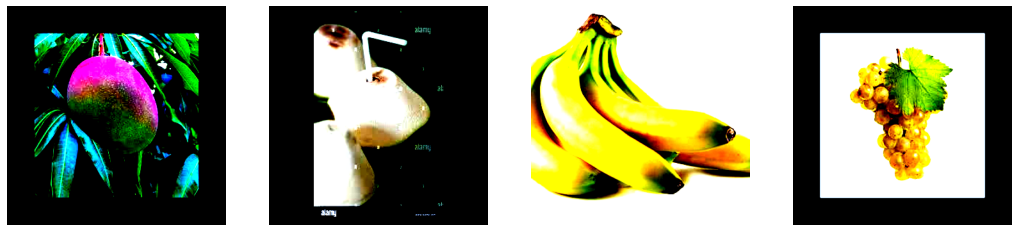

In [ ]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

### Implementacion de los modelos

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [ ]:
model_inceptionv3 = torchvision.models.inception_v3(weights=weights)

for param in model_inceptionv3.parameters():
    param.requires_grad = False

last_layer_in_features = model_inceptionv3.fc.in_features
model_inceptionv3.fc = nn.Linear(last_layer_in_features, 11)

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs, path):
  
  train_loss = []
  train_acc = []
  valid_loss = []
  valid_acc = []
  model = model.to(device=device) 
  
  for epoch in range(epochs):
    model.train()
    loss_var = 0
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    for idx, (images, labels) in enumerate(train_loader):

        images = images.to(device=device)
        labels = labels.to(device=device)

        optimizer.zero_grad()
        
        output , _ = model(images)

        loss = criterion(output,labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        accuracy = conv_model_accuracy(output, labels)
        epoch_train_accuracy += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)

    epoch_valid_loss = 0.0
    epoch_valid_accuracy = 0.0

    with torch.no_grad():
        model.eval()
        correct = 0
        samples = 0
        for idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            output = model(images)
            epoch_valid_loss += criterion(output, labels).item()
            epoch_valid_accuracy += conv_model_accuracy(output, labels).item()
      
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
       
    print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
    epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc
    
    torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'train_acc': epoch_train_accuracy,
            'valid_loss': epoch_valid_loss,
            'valid_acc': epoch_valid_accuracy,
            }, path)
    
  return model, history

In [ ]:
criterion = nn.CrossEntropyLoss()
conv_model_accuracy = torchmetrics.Accuracy()
conv_model_accuracy.to(device=device)

Accuracy()

In [ ]:
def ploteo(history):
  fig, axs = plt.subplots(2, 1, figsize=(15,15))
  axs[0].plot(history['train_loss']) 
  axs[0].plot(history['valid_loss']) 
  axs[0].title.set_text('Error de Entrenamiento vs Validación') 
  axs[0].legend(['Train', 'Valid'])  
  axs[1].plot(history['train_acc']) 
  axs[1].plot(history['valid_acc'])
  axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
  axs[1].legend(['Train', 'Valid'])

In [ ]:
def test(model, criterion, test_loader):

  test_loss = 0.0
  test_accuracy = 0.0

  for test_data, test_target in test_loader:
    if torch.cuda.is_available():
          test_data, test_target = test_data.cuda(), test_target.cuda()
    output = model(test_data)
    test_loss += criterion(output, test_target).item()
    test_accuracy += conv_model_accuracy(output, test_target).item()

  test_loss = test_loss / len(test_loader)
  test_accuracy = test_accuracy / len(test_loader)

  print("El modelo logro un error de TETS de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

Epoch: 1/20 - Train loss 1.869702 - Train Accuracy 0.435636 - Valid Loss 1.390061 - Valid Accuracy 0.617647
Epoch: 2/20 - Train loss 1.187807 - Train Accuracy 0.701377 - Valid Loss 0.972120 - Valid Accuracy 0.800158
Epoch: 3/20 - Train loss 0.901981 - Train Accuracy 0.781038 - Valid Loss 0.847328 - Valid Accuracy 0.783876
Epoch: 4/20 - Train loss 0.787613 - Train Accuracy 0.793220 - Valid Loss 0.733568 - Valid Accuracy 0.826681
Epoch: 5/20 - Train loss 0.725871 - Train Accuracy 0.799343 - Valid Loss 0.679177 - Valid Accuracy 0.825893
Epoch: 6/20 - Train loss 0.670170 - Train Accuracy 0.815466 - Valid Loss 0.643430 - Valid Accuracy 0.831670
Epoch: 7/20 - Train loss 0.624205 - Train Accuracy 0.830826 - Valid Loss 0.603032 - Valid Accuracy 0.844800
Epoch: 8/20 - Train loss 0.543669 - Train Accuracy 0.848369 - Valid Loss 0.579831 - Valid Accuracy 0.851366
Epoch: 9/20 - Train loss 0.566749 - Train Accuracy 0.831441 - Valid Loss 0.552850 - Valid Accuracy 0.864758
Epoch: 10/20 - Train loss 0.

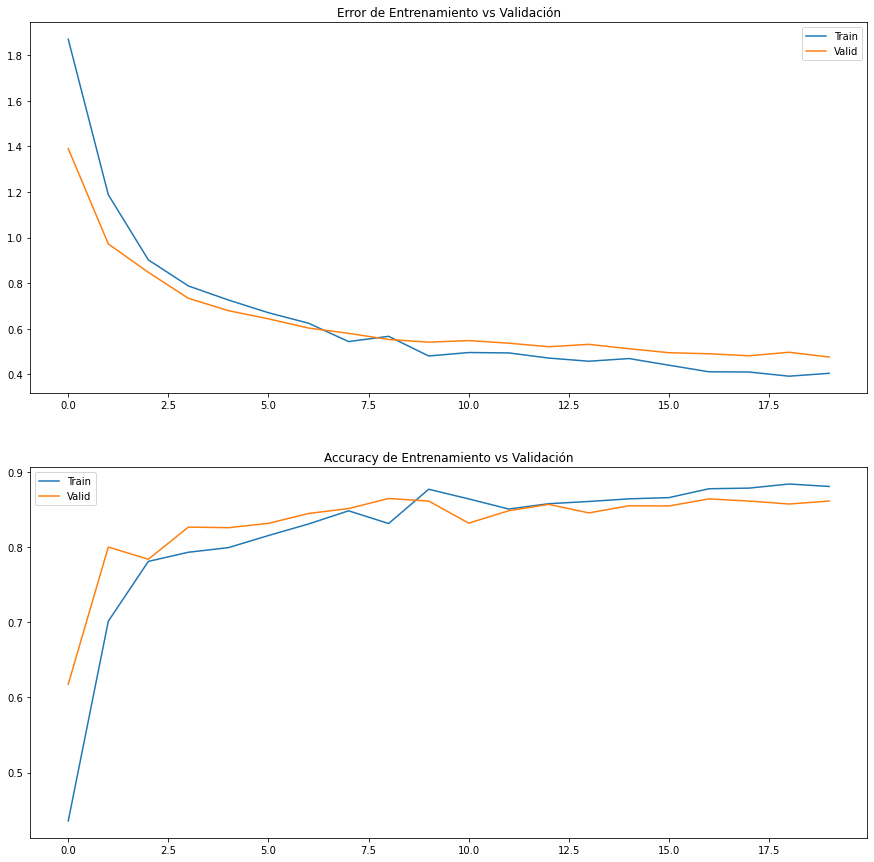

In [ ]:
filename = '/content/drive/MyDrive/Colab_Notebooks/CEIA/VPC2/TP/Fruit_multiclass/Models/Result/TL-1.pt'
optimizer_inceptionv3 = torch.optim.Adam(model_inceptionv3.parameters(), lr= 0.001)
result_model_inceptionv3, history_inceptionv3 = train(model_inceptionv3, criterion, optimizer_inceptionv3, train_loader, valid_loader, 20,filename)
ploteo(history_inceptionv3)
test(model_inceptionv3, criterion, test_loader)